# feature extraction for logistic ADNI models
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets.MRI_3D_nolabels_inram_ds import MRI_3D_nolabels_inram_ds

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

### Loading ADNI flair mask t1 dataset

In [3]:
# ADNI_ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

In [4]:
# IDs = ADNI_ds.getIDs()

In [5]:
# len(IDs)

### Loading ADNI predictions

In [6]:
# def get_output_maps_for_ds(output_maps_dir, ids):
#     output_maps_lists = defaultdict(lambda : [])
#     key_order = None
#     for ID in tqdm(ids, position=0, leave=True):
#         output_maps_data = np.load(f"{output_maps_dir}{ID}_out_maps.npz")
#         key_order = natsorted(list(output_maps_data.keys()))
#         for output_type in key_order:
#             output_maps_lists[ID].append(torch.from_numpy(output_maps_data[output_type]))
            
#     return output_maps_lists, key_order
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True):
        # print(fID)
        # break
        if ".npz" in fID:
            ID = fID.split(".")[0]
            output_maps_data = np.load(output_maps_dir+fID)
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:
# model_name = "SSN_Ens_Mean"
model_name = "deterministic"
output_maps_dir = f"/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_output_maps/{model_name}/"
output_maps_for_umaps, key_order = load_output_maps(output_maps_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [01:02<00:00,  4.65it/s]


In [11]:
# model_name_for_pred = "SSN_Ens_Mean"
model_name = "deterministic"

output_maps_for_pred = output_maps_for_umaps
key_order_for_pred = key_order

In [12]:
key_order

['ent', 'pred', 'seg']

In [13]:
ID = list(output_maps_for_umaps.keys())[2]

In [14]:
img_us = output_maps_for_umaps[ID]
img_ps = output_maps_for_pred[ID]

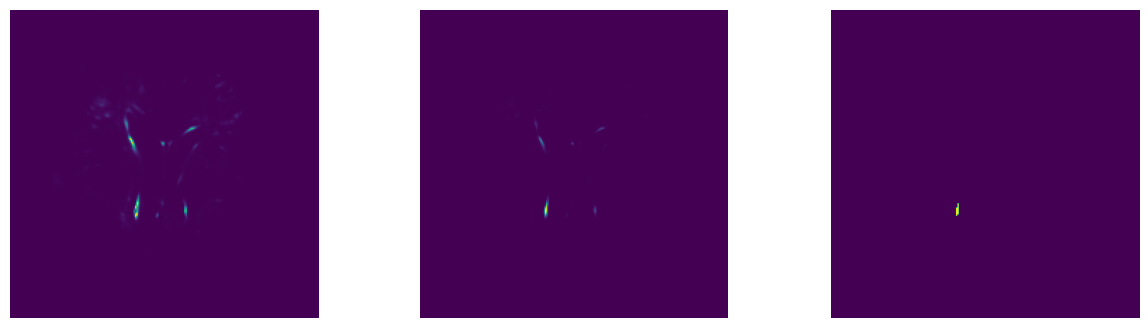

In [15]:
ent, pred, seg = img_ps
plt.figure(figsize=(15,4))
islice = 31
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(img_ps[i][islice])
    plt.axis('off')

In [16]:
t = 0.1
ent_voxels = ent[ent > t]
pred_voxels = pred[pred > t]
# var_voxels = var[var > t/10]

<Axes: ylabel='Density'>

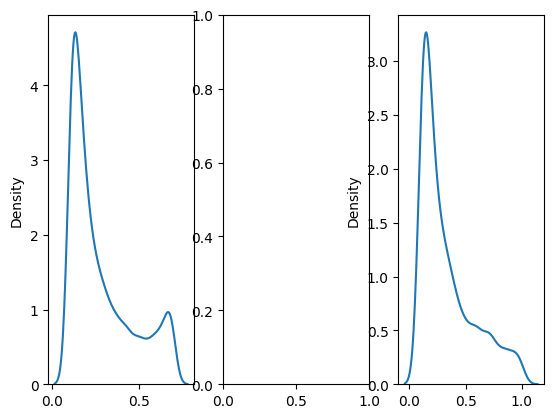

In [39]:
plt.subplot(1,3,1)
sns.kdeplot(ent_voxels)
plt.subplot(1,3,2)
# sns.kdeplot(var_voxels)
plt.subplot(1,3,3)
sns.kdeplot(pred_voxels)

In [40]:
def histogram_distribution(values, bins=20, minv=None, maxv=None):
    # so that the output values are meaningful, I need to carefully set the min a max. mnin should be t, and max should be the max across all the data I think.
    if minv == None:
        minv = values.min()
    if maxv == None:
        maxv = values.max()
    counts = torch.zeros(bins)
    bounds = torch.arange(minv,maxv, (maxv-minv)/bins)
    for i, (lower_bound, upper_bound) in enumerate(zip(bounds[:-1], bounds[1:])):
        counts[i] = ((values >= lower_bound) * (values < upper_bound)).sum()

    Z = counts.sum()
    counts = counts / Z
    return counts

In [41]:
def gaussian_summary_statistics(values):
    sum = values.sum().item()
    mean = values.mean().item()
    std = values.std().item()
    skew = scipy.stats.skew(values)
    kurtosis = scipy.stats.kurtosis(values, fisher=False)
    return sum, mean, std, skew, kurtosis

In [42]:
histogram_distribution(ent_voxels, 20)

tensor([0.2193, 0.1494, 0.1087, 0.0783, 0.0614, 0.0501, 0.0405, 0.0369, 0.0317,
        0.0279, 0.0258, 0.0220, 0.0200, 0.0215, 0.0171, 0.0195, 0.0216, 0.0231,
        0.0253, 0.0000])

In [43]:
# counts, counts.sum()

<Axes: ylabel='Count'>

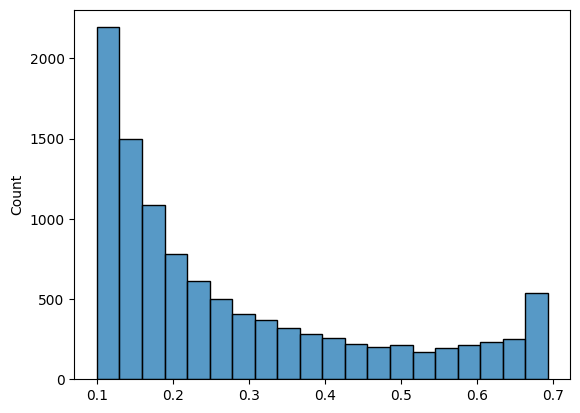

In [44]:
sns.histplot(ent_voxels, bins=20)

### overlap proportions computation
- [x] proportion of segmented area that is uncertain
- [x] proportion of uncertain area that is segmented
- [x] proportion of uncertain area that is within segmentation + edge expansion

In [45]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

### loading the ventricles for ventricle distance analysis

In [46]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as tv

# resamples an image
def get_resampled_img(itk_image, out_spacing=[2.0, 2.0, 2.0], original_spacing=[1., 1., 3.], is_label=False):
    
    if not original_spacing:
        # orig spacing can be specified when the input itk_image does not know its actual spacing.
        original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    # what's this? its how to modify the output size I think...
    out_size = [
        int(np.round(orig_size * orig_spacing / out_spacing))
        for (orig_size, orig_spacing, out_spacing) 
        in zip(original_size, original_spacing, out_spacing)
    ]
    
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())      # sets the output direction cosine matrix...
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)
      
def resample_and_return(filename_in, is_label=False, out_spacing=[1., 1., 3.], original_spacing=None):
    """
    resamples an image to custom voxel dimensions and returns image as a numpy array
    
    filename_in: .nii.gz file to load
    is_label: is the file a brain scan or a segmentaion mask
    outspacing: the spacing of the image to be resampled to.
    """
        
    # resample the image
    image = sitk.ReadImage(filename_in)
    resampled_image = get_resampled_img(image, out_spacing=out_spacing, original_spacing=original_spacing, is_label=is_label)
    
    return sitk.GetArrayFromImage(resampled_image)

In [47]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((220, 220))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [48]:
IDs_outmaps = natsorted(list(output_maps_for_umaps.keys()))
IDs = [("_".join(idx.split("_")[:-2]), idx) for idx in IDs_outmaps if "out_maps" in idx]

In [49]:
output_maps_for_umaps[IDs[0][1]][0].shape

torch.Size([58, 220, 220])

In [52]:
vent_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300_ventmapper/"
vent_filenames = os.listdir(vent_folder)
ID_ventpath_map = {"_".join(f.split("_")[:-1]): vent_folder + f for f in vent_filenames}
vent_maps = []
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    num_slices = output_maps_for_umaps[ID[1]][0].shape[0]
    vent_path = ID_ventpath_map[ID[0]]
    vent_seg = load_fast_output(vent_path, num_slices)
    vent_maps.append(vent_seg)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:25<00:00, 11.27it/s]


In [53]:
vent_maps[0].shape, vent_maps[0].sum(dim=(1,2,)).argmax(0)

(torch.Size([58, 220, 220]), tensor(33))

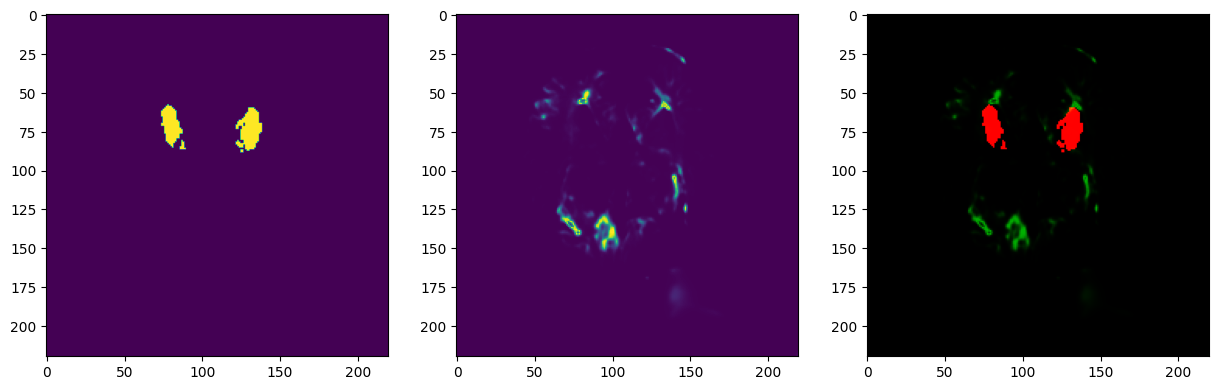

In [54]:
islice = 26
scan_id = 200
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(vent_maps[scan_id][islice])
plt.subplot(1,3,2)
plt.imshow(output_maps_for_umaps[IDs[scan_id][1]][0][islice])
plt.subplot(1,3,3)
img_map = torch.zeros(*vent_maps[0].shape[1:], 3)
img_map[:,:,0] = vent_maps[scan_id][islice]
img_map[:,:,1] = output_maps_for_umaps[IDs[scan_id][1]][0][islice]
plt.imshow(img_map)

### distance from the ventricles

In [55]:
import torch.nn.functional as F
def edge_pixels_3D(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32).unsqueeze(0)
    
    max_pool = F.max_pool3d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool3d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype).squeeze()

def edge_pixels(img):
    dtype = img.dtype # preserve original datatype for casting at the end
    img = img.type(torch.float32)
    
    max_pool = F.max_pool2d(img, 3, stride=1, padding=1)
    outer_edge = (max_pool != img).type(torch.float32)
    
    dilated_edge = F.max_pool2d(outer_edge, 3, stride=1, padding=1)
    inner_edge = dilated_edge * img
    
    return inner_edge.type(dtype)

In [56]:
def downsample_3d(img, avg=True):
    if avg:
        return F.avg_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)
    else:
        return F.max_pool3d(img.unsqueeze(0).type(torch.float32), 2, stride=2).squeeze().type(img.dtype)

In [57]:
def min_distances(img, vmap):
    # calculate the minimum distance between each point in a and each point in b
    
    spatial_dims = vmap.squeeze().shape
    grid = torch.stack(
            torch.meshgrid(
                *[torch.arange(0, sdi, 1) for sdi in spatial_dims],
                indexing='ij'
            )
        ).type(torch.float32).to(img.device)
    
    a = grid[:, img.squeeze() > 0].T.cuda()
    b = grid[:, vmap.squeeze() > 0].T.cuda()
    
    # Calculate pairwise distances between all pairs of points
    distances = torch.cdist(a, b)

    # Find indices of closest points in b for each point in a
    _, indices = torch.min(distances, dim=1)

    # Use indices to index into b and get closest points
    b_closest = b[indices]

    # Calculate distances to closest points 
    distances_closest = torch.norm(a - b_closest, dim=1)
    
    distance_map = torch.zeros(img.shape).to(distances_closest.device)
    distance_map[img > 0] = distances_closest
    
    return distances_closest, distance_map

### connected components analysis

In [58]:
import cc3d

In [59]:
def get_conn_comps(img):
    connectivity = 6 # only 4,8 (2D) and 26, 18, and 6 (3D) are allowed
    labels_out_seg = cc3d.connected_components(img.cpu().numpy(), connectivity=connectivity)
    return torch.from_numpy(labels_out_seg.astype(np.int16)).to(img.device)

In [60]:
def get_edge_expanded_seg(seg, expansions=2):
    expanded = seg.type(torch.float32).unsqueeze(1)
    for _ in range(expansions):
        expanded = torch.nn.functional.max_pool3d(expanded, kernel_size=3, padding=1, stride=1)
    return expanded.type(seg.dtype).squeeze()

In [61]:
def skew(t, dim=None):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`

    :return: a scalar
    """

    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(3)).mean(dim=dim)


def kurtosis(t, fisher=True, dim=None):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`tntorch.cross()`).

    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)

    :return: a scalar
    """
        
    return (((t-t.mean(dim=dim).unsqueeze(dim))/t.std(dim=dim).unsqueeze(dim)).pow(4)).mean(dim=dim) - fisher*3

In [62]:
def one_hot_encoded_image(image):
    # for a 3D [H, W, D] shape image
    # ensure all IDs are unique
    return (image == image.unique().view(-1, 1, 1, 1))

def one_hot_encoded_vector(vector):
    return (vector == vector.unique().view(-1,1))

In [63]:
def conn_comp_basic_stats(umap, conn_comp_map, seg_map, dist_map):
    # number of connected components
    # size of connected components
    # connected component size distribution information
    cc_ids = conn_comp_map.unique()
    cc_locs = conn_comp_map != 0
    conn_comp_map = conn_comp_map[cc_locs]
    umap = umap[cc_locs]
    seg_map = seg_map[cc_locs]
    dist_map = dist_map[cc_locs]
    
    assert dist_map.shape == seg_map.shape == umap.shape == conn_comp_map.shape
    num_ccs = len(cc_ids) - 1
    num_ccs_no_overlap = 0
    cc_sizes = []
    cc_means = []
    cc_stds = []
    cc_skews = []
    cc_kurts = []
    cc_vent_dists = []
    for cc_id in cc_ids:
        if cc_id == 0:
            continue
        cc = conn_comp_map == cc_id
        cc_size = cc.sum().item()
        cc_values = umap[cc]
        _, mean, std, skew, kurtosis = gaussian_summary_statistics(cc_values.cpu())
    
        cc_sizes.append(cc_size)
        cc_means.append(mean)
        cc_stds.append(std)
        cc_skews.append(skew)
        cc_kurts.append(kurtosis)
        
        if seg_map[cc].sum() == 0:
            num_ccs_no_overlap += 1
            
        cc_vent_dists.append(dist_map[cc].mean().item())
    _, vd_mean, vd_std, vd_skew, vd_kurt = gaussian_summary_statistics(torch.Tensor(cc_vent_dists))
    _, size_mean, size_std, size_skew, size_kurt = gaussian_summary_statistics(torch.Tensor(cc_sizes))
    
    return {"num":num_ccs, "sizes":cc_sizes, "means":cc_means, "stds":cc_stds, "skews":cc_skews, "kurts":cc_kurts, "vent_dists":cc_vent_dists, "unsegmented_ccs":num_ccs_no_overlap, "size_mean":size_mean, "size_std":size_std, "size_skew":size_skew, "size_kurt":size_kurt, "vd_mean":vd_mean, "vd_std":vd_std, "vd_skew":vd_skew, "vd_kurt":vd_kurt}



In [64]:
# idx = 0
# example_umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
# example_smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
# example_vmap = vent_maps[idx].cuda()

# vmap_ds = downsample_3d(example_vmap)
# umap_ds = downsample_3d(example_umap)
# ut_ds = umap_ds > 0.1
# ut = example_umap > 0.1
# conn_comps = get_conn_comps(ut)

# distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
# distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), example_umap.shape, mode='trilinear').squeeze()

In [65]:
# cc_data = conn_comp_basic_stats(example_umap, conn_comps, example_smap, distance_map) # from this we could get the mean mean, mean std, mean skew and mean kurtosis for each threshold I guess. # that would be somewhat interesting

In [66]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [67]:
# cc_data["log_sizes"] = torch.Tensor(cc_data['sizes']).log()
# sns.jointplot(cc_data, y="vent_dists", x="log_sizes", bins=5, kind='hist')

In [68]:
def joint_hist_values(data, x, y, minx, maxx, miny, maxy, bins=5):
    values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
    values = values.expand((bins, bins, *values.shape))
    counts = torch.zeros(bins, bins)
    bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1)).to(values.device)
    bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1)).to(values.device)
    upper_xlims = bounds_x[1:].view(1, 5, 1)
    upper_ylims = bounds_y[1:].view(5, 1, 1)
    lower_xlims = bounds_x[:-1].view(1, 5, 1)
    lower_ylims = bounds_y[:-1].view(5, 1, 1)
    counts = (values[:,:,:,0] < upper_xlims) * (values[:,:,:,0] > lower_xlims) * (values[:,:,:,1] < upper_ylims) * (values[:,:,:,1] > lower_ylims)
    counts = counts.sum(dim=-1)

    Z = counts.sum()
    counts = counts / Z
    return counts


# def joint_hist_values2(data, x, y, minx, maxx, miny, maxy, bins=5):
#     values = torch.stack([torch.Tensor(data[x]), torch.Tensor(data[y])], dim=1) # shape [N, 2]
#     #values = values.expand((bins, bins, *values.shape))
#     counts = torch.zeros(bins, bins)
#     bounds_x = torch.arange(minx,maxx, (maxx-minx)/(bins+1))
#     bounds_y = torch.arange(miny,maxy, (maxy-miny)/(bins+1))
#     upper_xlims = bounds_x[1:]
#     upper_ylims = bounds_y[1:]
#     lower_xlims = bounds_x[:-1]
#     lower_ylims = bounds_y[:-1]
#     for i, (x1, x2) in enumerate(zip(lower_xlims, upper_xlims)):
#         for j, (y1,y2) in enumerate(zip(lower_ylims, upper_ylims)):
#             counts[i][j] = ((values[:,0] < x2) * (values[:,0] > x1) * (values[:,1] < y2) * (values[:,1] > y1)).sum()
#     # counts = counts.sum(dim=-1)

#     Z = counts.sum()
#     counts = counts / Z
#     return counts

In [69]:
# joint_counts = joint_hist_values2(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5)

In [70]:
# joint_counts.shape

In [71]:
# plt.imshow(joint_counts); plt.colorbar()

In [72]:
# cc_data["num"], cc_data["unsegmented_ccs"]

In [73]:
# summary statistics of log conn comp size:
# cc_summary_stats = gaussian_summary_statistics(torch.Tensor(cc_data['sizes']).log())

In [74]:
# sum, mean , std, skew, kurtosis of log size of connected components.
# cc_summary_stats

In [75]:
# histogram_distribution(torch.Tensor(cc_data['sizes']).log(), 10)

In [76]:
# plt.hist(torch.Tensor(cc_data['sizes']).log(), bins=10);

In [77]:
# sns.jointplot(data=cc_data, x="sizes", y="kurts")
# plt.xscale('log')

In [78]:
# lets get basic distribution of connected component numbers and size. Then we can get some interesting plots later, so collect as much interesting information as possible...
# I can compare this to number and size of connected components in the predicted map (at say tau > 0.5?)
# I should get distance of each connected component from the ventricles and size. yes that is a good plot
# also distance from the binarized segmentation... (but I need to be careful and do this for pred as well as umap).

### Uncertainty values that I intended to extract from the umap

For SSN Ens for the ent and var maps, and SSN Ens Mean for the pred and seg maps. Nice.
I should capture all of these metrics across a variety of metrics, and I can tune the thresholds in cross validation. simples.
It may be the case that ent + var together give us some more information. That would be interesting.

`output_maps_for_umaps` is the SSN_Ens output
`output_maps_for_mean` is the SSN_Ens_mean output

- [x] sum
- [x] mean
- [x] std
- [x] skew
- [x] kurtosis
- [x] kde bins?
- [x] ventricle size
- [x] intensity distribution (need to ensure that the min and max of the bins are the same across all individuals) 
- [x] number of connected components
- [x] size of connected components distribution, need to ensure that the min and max of the bins are the same across all individuals.
- [x] number / distribution of connected components that have no overlap with the segmented mask... (again I need the umap and the pred map to do this) (and I should also compare to the seg map as well perhaps)
- [x] uncertainty sum, mean, skew, kurtosis of each connected component. That may be interesting to plot.
- [-] distance to the WMH binarized segmentation for each connected component (try to separate out those connected components that are highlighting other stuff).
- [-] proportion of the segmented edge deemed uncertain (if we expand the edge of the segmentation then calculate the proportion, we can get the sum of the uncertainty that
- [x] proportion of segmented area deemed uncertain (this requires access to SSN Ens and SSN Ens Mean at the same time
- [x] proportion of uncertain area that is within the segmentation + edge area
- [x] distribution of size of connected components (sum, mean, std, skew)
- [x] distance from the ventricles (could do this in x, y and z distributions, or just overall...) I could measure distance x intensity
- [x] stats for distance from the ventricles (mean, std, skew, kurtosis, etc)
- [x] mean distance from the ventricles of each connected component joint with size in a 5x5 and 10x10 bin option I think. again ensure that the 
- [ ] predicted seg volume.

### turning all of the above into a big loop

need to compute values for:
- [x] ent map
- [x] var map
- [x] pred map
- [x] loop over [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] as threshold for ent map
- [x] loop over [0.1, 0.2, 0.3, 0.4, 0.5, 0.6] for pred map
- [x] loop over ? for ent map

In [79]:
data = {}
failed_ids = []
for idx in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[idx][0]
    print(ID)
    try:
        vmap = vent_maps[idx].cuda()
        smap = output_maps_for_pred[IDs[idx][1]][2].cuda()
        smap_expanded = get_edge_expanded_seg(smap)
        seg_volume = smap.sum().item()
        vent_volume = vmap.sum().item()
        vmap_ds = downsample_3d(vmap)

        ind_data = {}

        for input_type in ["ent", "pred"]:
            if input_type == "ent":
                umap = output_maps_for_umaps[IDs[idx][1]][0].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5]
                maxv = 0.7
            # elif input_type == "var":
            #     umap = output_maps_for_umaps[IDs[idx][1]][3].cuda()
            #     ts = [0.01, 0.03, 0.06, 0.09, 0.12, 0.15]
            #     maxv = 0.2
            elif input_type == "pred":
                umap = output_maps_for_pred[IDs[idx][1]][1].cuda()
                ts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
                maxv = 1.0
            else:
                raise ValueError  

            umap_ds = downsample_3d(umap)

            collected_data_t = {}

            for t in ts:
                ut = umap > t
                umap_values = umap[ut]

                #### summary statistics
                sum, mean, std, skew, kurtosis = gaussian_summary_statistics(umap_values.cpu())
                values_hist = histogram_distribution(umap_values, bins=20, minv=t, maxv=maxv)

                #### overlap statistics
                intersection = (ut * smap).sum()
                expanded_intersection = (ut * smap_expanded).sum()

                prop_umap_segmented = (intersection / ut.sum()).item()
                prop_umap_within_expanded_seg = (expanded_intersection / ut.sum()).item()
                prop_seg_uncertain = (intersection / smap.sum()).item()

                ### ventricle distance statistics
                ut_ds = umap_ds > t
                distances_closest, distance_map = min_distances(ut_ds, vmap_ds)
                distance_map = F.interpolate(distance_map.view(1, 1, *distance_map.shape), umap.shape, mode='trilinear').squeeze()
                _, dist_mean, dist_std, dist_skew, dist_kurt = gaussian_summary_statistics(distances_closest.cpu())
                umap_ds_values = umap_ds[ut_ds]
                dist_value_joint = joint_hist_values({"x":distances_closest, "y":umap_ds_values}, x="x", y="y", minx=0, maxx=30, miny=t, maxy=maxv, bins=5).cpu()

                ### connected component analysis statistics
                conn_comps = get_conn_comps(ut)
                cc_data = conn_comp_basic_stats(umap, conn_comps, smap, distance_map)
                cc_data["log_sizes"] = torch.Tensor(cc_data["sizes"]).log()
                cc_size_dist_joint = joint_hist_values(cc_data, "log_sizes", "vent_dists", 0, 8, 0, 10, 5).cpu()

                # recorded values
                all_data = {}
                for key, value in cc_data.items():
                    all_data["cc_" + key] = value
                all_data["sum"] = sum
                all_data["mean"] = mean
                all_data["std"] = std
                all_data["skew"] = skew
                all_data["kurtosis"] = kurtosis
                all_data["prop_umap_segmented"] = prop_umap_segmented
                all_data["prop_umap_within_expanded_seg"] = prop_umap_within_expanded_seg
                all_data["prop_seg_uncertain"] = prop_seg_uncertain
                all_data["dist_mean"] = dist_mean
                all_data["dist_std"] = dist_std
                all_data["dist_skew"] = dist_skew
                all_data["dist_kurt"] = dist_kurt
                all_data["dist_value_joint"] = dist_value_joint
                all_data["cc_dist_value_joint"] = cc_size_dist_joint
                all_data["seg_volume"] = seg_volume
                all_data["vent_volume"] = vent_volume
                all_data["values_hist"] = values_hist

                print(all_data["cc_num"], all_data["cc_unsegmented_ccs"])
                collected_data_t[str(t)] = all_data


                # break

            ind_data[input_type] = collected_data_t
            # break

        data[ID] = ind_data
        # break
    except:
        failed_ids.append((idx, ID))
    # break
        

  0%|                                                                                                                                                                 | 0/290 [00:00<?, ?it/s]

ADNI_002_S_0729_20110816


/tmp/ipykernel_2836729/1284179010.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = scipy.stats.skew(values)
/tmp/ipykernel_2836729/1284179010.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = scipy.stats.kurtosis(values, fisher=False)


112 98
100 79
99 65
194 94
250 103
376 141
78 53
94 54
83 34
75 20
63 0


  0%|▌                                                                                                                                                        | 1/290 [00:03<16:50,  3.50s/it]

54 0
ADNI_002_S_1155_20111222
248 220
174 141
169 129
151 102
144 91
153 88
167 128
110 65
77 27
73 17
66 0


  1%|█                                                                                                                                                        | 2/290 [00:06<15:04,  3.14s/it]

52 0
ADNI_002_S_1261_20110314
123 111
108 91
92 70
82 58
88 54
101 53
82 62
59 37
48 19
43 9


  1%|█▌                                                                                                                                                       | 3/290 [00:08<12:07,  2.53s/it]

47 0
48 0
ADNI_002_S_1280_20110504
195 166
153 117
150 104
176 90
234 100
343 126
122 82
100 52
83 30
70 16


  1%|██                                                                                                                                                       | 4/290 [00:11<13:34,  2.85s/it]

66 0
64 0
ADNI_002_S_2010_20101022
181 164
113 95
87 62
84 48
88 41
96 37
77 53
53 25
51 20
40 8


  2%|██▋                                                                                                                                                      | 5/290 [00:13<11:44,  2.47s/it]

34 0
24 0
ADNI_002_S_4213_20111205
236 211
166 129
144 101
145 89
142 80
165 82
140 96
114 64
87 32
77 16
71 0


  2%|███▏                                                                                                                                                     | 6/290 [00:16<12:13,  2.58s/it]

55 0
ADNI_002_S_4225_20111226
278 245
220 178
213 159
204 134
200 113
227 109
194 141
142 78
130 57
118 33
103 0


  2%|███▋                                                                                                                                                     | 7/290 [00:19<13:58,  2.96s/it]

83 0
ADNI_002_S_4229_20111221
307 269
211 161
240 150
311 160
377 165
538 230
188 122
186 105
152 54
146 29
143 0


  3%|████▏                                                                                                                                                    | 8/290 [00:25<17:15,  3.67s/it]

131 0
ADNI_002_S_4237_20110926
354 310
319 252
359 242
497 251
653 287
880 367
298 212
290 179
271 133
238 66
212 0


  3%|████▋                                                                                                                                                    | 9/290 [00:32<23:20,  4.98s/it]

195 0
ADNI_002_S_4262_20111005
285 243
289 219
281 173
403 190
536 223
794 287
234 147
209 90
201 65
194 29
192 0


  3%|█████▏                                                                                                                                                  | 10/290 [00:39<25:32,  5.47s/it]

163 0
ADNI_002_S_4270_20111011
195 175
145 116
127 94
144 83
184 99
225 98
121 89
110 71
94 48
76 26
66 0


  4%|█████▊                                                                                                                                                  | 11/290 [00:42<21:41,  4.67s/it]

52 0
ADNI_002_S_4447_20120814
158 141
145 115
138 100
159 91
181 97
209 103
122 90
102 58
85 37
79 21


  4%|██████▎                                                                                                                                                 | 12/290 [00:45<18:59,  4.10s/it]

75 0
68 0
ADNI_002_S_4473_20120823
416 365
344 277
304 220
338 205
358 191
431 193
279 199
236 137
219 98
184 45
176 0


  4%|██████▊                                                                                                                                                 | 13/290 [00:51<21:27,  4.65s/it]

156 0
ADNI_002_S_4521_20120904
283 258
235 202
205 148
253 157
265 142
300 134
190 142
159 99
130 64
103 30


  5%|███████▎                                                                                                                                                | 14/290 [00:55<20:31,  4.46s/it]

88 0
83 0
ADNI_002_S_4654_20121023
253 225
171 136
144 106
142 86
163 80
204 84
132 93
83 41
74 26
62 11


  5%|███████▊                                                                                                                                                | 15/290 [00:57<18:07,  3.96s/it]

59 0
51 0
ADNI_006_S_4150_20111107
165 160
104 98
70 62
71 54
79 48
86 38
64 56
35 26
26 14
17 4


  6%|████████▍                                                                                                                                               | 16/290 [00:59<14:47,  3.24s/it]

18 0
9 0
ADNI_006_S_4153_20111104
174 170
113 105
106 93
108 88
104 77
115 82
106 94
93 73
88 54
74 25
76 0


  6%|████████▉                                                                                                                                               | 17/290 [01:01<13:31,  2.97s/it]

71 0
ADNI_006_S_4192_20111215
344 312
266 222
209 149
219 127
233 111
305 118
190 136
137 76
125 59
106 29


  6%|█████████▍                                                                                                                                              | 18/290 [01:05<15:02,  3.32s/it]

97 0
83 0
ADNI_006_S_4357_20111128
167 155
126 109
98 78
113 72
136 76
144 64
89 70
65 40
58 30


  7%|█████████▉                                                                                                                                              | 19/290 [01:08<13:23,  2.96s/it]

50 15
45 0
48 0
ADNI_006_S_4363_20111116
161 148
127 110
89 70
82 54
83 46
84 40
77 57
52 29
51 26
43 10


  7%|██████████▍                                                                                                                                             | 20/290 [01:09<11:47,  2.62s/it]

45 0
38 0
ADNI_006_S_4485_20120824
239 213
182 149
181 133
253 141
307 139
440 176
150 108
118 68
101 40
77 12
74 0


  7%|███████████                                                                                                                                             | 21/290 [01:13<13:28,  3.00s/it]

65 0
ADNI_006_S_4679_20120601
226 211
155 133
149 116
167 90
209 93
254 102
125 99
94 61
69 30
59 14


  8%|███████████▌                                                                                                                                            | 22/290 [01:16<13:17,  2.97s/it]

53 0
51 0
ADNI_006_S_4713_20121128
152 141
116 98
108 89
110 74
124 67
156 67
92 74
75 46
67 37


  8%|████████████                                                                                                                                            | 23/290 [01:18<12:08,  2.73s/it]

46 11
48 0
46 0
ADNI_006_S_4960_20121009
245 222
218 177
236 175
248 155
277 153
315 160
205 154
177 109
163 76
157 49


  8%|████████████▌                                                                                                                                           | 24/290 [01:23<14:14,  3.21s/it]

129 0
108 0
ADNI_009_S_2208_20101201
188 166
132 104
105 66
125 66
132 59
165 73
89 59
75 43
72 37


  9%|█████████████                                                                                                                                           | 25/290 [01:25<12:54,  2.92s/it]

54 18
39 0
34 0
ADNI_009_S_4324_20111101
186 175
128 111
116 91
139 82
139 67
165 69
97 78
65 44
51 29


  9%|█████████████▋                                                                                                                                          | 26/290 [01:27<12:03,  2.74s/it]

53 25
37 0
27 0
ADNI_009_S_4359_20111205
127 117
86 73
73 51
101 55
126 60
157 64
69 51
53 34
45 21
46 16


  9%|██████████████▏                                                                                                                                         | 27/290 [01:29<10:53,  2.48s/it]

47 0
45 0
ADNI_009_S_4388_20111213
161 150
128 114
96 79
109 66
127 63
168 75
84 69
73 52
47 25
38 15


 10%|██████████████▋                                                                                                                                         | 28/290 [01:31<10:15,  2.35s/it]

25 0
23 0
ADNI_009_S_4543_20120912
123 109
89 72
89 61
117 55
152 63
217 84
73 54
71 46
65 32


 10%|███████████████▏                                                                                                                                        | 29/290 [01:33<09:55,  2.28s/it]

48 10
45 0
37 0
ADNI_009_S_4612_20121011
172 148
166 128
175 111
298 129
438 159
594 208
144 91
135 62
136 46
132 26
127 0


 10%|███████████████▋                                                                                                                                        | 30/290 [01:38<12:56,  2.98s/it]

118 0
ADNI_009_S_4741_20121015
222 199
161 133
150 113
146 88
171 96
222 96
137 104
101 61
80 38
64 17


 11%|████████████████▏                                                                                                                                       | 31/290 [01:41<12:42,  2.94s/it]

58 0
58 0
ADNI_010_S_4345_20120920
191 176
134 116
132 107
136 88
161 90
207 91
106 85
74 49
71 41


 11%|████████████████▊                                                                                                                                       | 32/290 [01:43<12:03,  2.81s/it]

46 15
34 0
33 0
ADNI_011_S_0021_20101008
225 207
195 170
146 115
137 93
137 77
153 73
139 109
83 47
67 27
68 20


 11%|█████████████████▎                                                                                                                                      | 33/290 [01:46<11:46,  2.75s/it]

55 0
35 0
ADNI_011_S_0023_20121227
247 230
177 155
146 116
152 89
173 91
198 92
132 105
98 68
86 51
58 19


 12%|█████████████████▊                                                                                                                                      | 34/290 [01:49<11:49,  2.77s/it]

48 0
41 0
ADNI_011_S_2274_20110818
297 274
243 209
195 153
215 132
239 136
280 130
192 153
135 87
109 58
93 35


 12%|██████████████████▎                                                                                                                                     | 35/290 [01:52<13:04,  3.08s/it]

78 0
60 0
ADNI_011_S_4075_20111214
184 176
111 101
91 79
88 64
104 59
155 75
86 75
64 49
48 32
32 15


 12%|██████████████████▊                                                                                                                                     | 36/290 [01:54<11:34,  2.73s/it]

20 0
15 0
ADNI_011_S_4105_20111005
234 219
165 148
123 99
120 74
136 77
147 71
99 81
74 55
53 30


 13%|███████████████████▍                                                                                                                                    | 37/290 [01:57<11:02,  2.62s/it]

48 18
41 0
33 0
ADNI_011_S_4120_20111010
187 171
107 88
104 80
130 80
159 77
213 95
89 70
76 52
57 32


 13%|███████████████████▉                                                                                                                                    | 38/290 [01:59<10:38,  2.53s/it]

50 20
44 0
32 0
ADNI_011_S_4222_20111207
176 164
127 109
120 99
136 76
158 71
224 79
103 82
70 48
52 24
36 7


 13%|████████████████████▍                                                                                                                                   | 39/290 [02:01<10:22,  2.48s/it]

30 0
29 0
ADNI_011_S_4235_20111219
274 261
193 172
169 142
168 116
173 105
210 102
151 123
100 68
83 41
67 18


 14%|████████████████████▉                                                                                                                                   | 40/290 [02:05<11:11,  2.68s/it]

74 0
64 0
ADNI_011_S_4278_20111013
248 227
174 149
140 109
134 93
147 86
195 88
131 100
98 63
85 45
70 23


 14%|█████████████████████▍                                                                                                                                  | 41/290 [02:07<11:14,  2.71s/it]

58 0
44 0
ADNI_011_S_4547_20120912
299 276
214 187
175 137
216 136
262 132
350 143
160 129
137 95
109 63
86 33


 14%|██████████████████████                                                                                                                                  | 42/290 [02:11<12:31,  3.03s/it]

67 0
62 0
ADNI_012_S_4012_20111107
172 160
94 82
87 69
87 58
87 50
100 49
77 57
56 33
48 23
43 15
32 0


 15%|██████████████████████▌                                                                                                                                 | 43/290 [02:13<10:55,  2.65s/it]

31 0
ADNI_012_S_4094_20111006
181 170
111 95
95 76
89 60
77 46
87 51
92 74
65 41
51 23
36 7


 15%|███████████████████████                                                                                                                                 | 44/290 [02:15<09:48,  2.39s/it]

32 0
22 0
ADNI_012_S_4128_20111101
238 207
233 193
212 160
238 150
259 139
344 161
189 141
162 104
143 63
128 33
119 0


 16%|███████████████████████▌                                                                                                                                | 45/290 [02:19<11:57,  2.93s/it]

121 0
ADNI_012_S_4188_20111213
229 196
163 122
140 89
139 73
176 79
204 84
116 72
85 39
84 30
71 14


 16%|████████████████████████                                                                                                                                | 46/290 [02:22<11:42,  2.88s/it]

64 0
48 0
ADNI_012_S_4545_20120924
226 201
165 135
143 109
139 83
154 85
205 91
128 95
89 52
67 29
55 13


 16%|████████████████████████▋                                                                                                                               | 47/290 [02:24<11:23,  2.81s/it]

50 0
44 0
ADNI_012_S_4643_20120627
171 160
120 106
84 67
84 59
97 56
116 53
77 61
57 38
45 25
37 15


 17%|█████████████████████████▏                                                                                                                              | 48/290 [02:26<10:07,  2.51s/it]

22 0
17 0
ADNI_013_S_1186_20110223
222 205
149 127
128 92
179 106
244 117
327 134
120 90
88 53
66 24
62 13


 17%|█████████████████████████▋                                                                                                                              | 49/290 [02:29<10:43,  2.67s/it]

55 0
43 0
ADNI_013_S_4268_20111101
216 191
144 115
119 84
114 76
109 66
116 67
105 73
83 50
65 29
55 13


 17%|██████████████████████████▏                                                                                                                             | 50/290 [02:32<10:17,  2.57s/it]

48 0
35 0
ADNI_013_S_4395_20120815
143 125
127 100
117 80
182 96
272 115
417 152
91 54
91 43
83 28
86 26
68 0


 18%|██████████████████████████▋                                                                                                                             | 51/290 [02:35<11:13,  2.82s/it]

65 0
ADNI_013_S_4580_20121015
258 235
213 177
171 127
178 116
204 118
259 132
160 117
140 89
116 55
91 25


 18%|███████████████████████████▎                                                                                                                            | 52/290 [02:39<12:25,  3.13s/it]

82 0
73 0
ADNI_013_S_4595_20121024
248 219
250 213
210 167
202 149
197 133
210 124
194 150
157 103
143 78
117 40
87 0


 18%|███████████████████████████▊                                                                                                                            | 53/290 [02:43<13:36,  3.45s/it]

69 0
ADNI_013_S_4616_20121025
334 304
294 243
309 219
354 201
460 221
610 262
262 192
229 143
199 95
180 57
152 0


 19%|████████████████████████████▎                                                                                                                           | 54/290 [02:50<17:32,  4.46s/it]

144 0
ADNI_014_S_2308_20110908
300 264
209 167
199 143
238 137
272 148
320 151
173 125
135 74
128 56
109 30
88 0


 19%|████████████████████████████▊                                                                                                                           | 55/290 [02:54<17:26,  4.45s/it]

87 0
ADNI_014_S_4039_20111208
187 168
143 120
110 83
114 69
119 74
124 68
104 80
90 58
71 33
55 12


 19%|█████████████████████████████▎                                                                                                                          | 56/290 [02:57<14:56,  3.83s/it]

52 0
38 0
ADNI_014_S_4058_20111222
205 180
147 114
161 118
199 118
228 120
296 141
134 94
108 59
96 40
84 18


 20%|█████████████████████████████▉                                                                                                                          | 57/290 [03:00<14:29,  3.73s/it]

76 0
72 0
ADNI_014_S_4079_20111215
139 130
93 80
83 63
108 68
126 67
138 64
75 55
62 40
48 22


 20%|██████████████████████████████▍                                                                                                                         | 58/290 [03:02<12:35,  3.26s/it]

33 4
39 0
33 0
ADNI_014_S_4263_20111006
372 326
299 240
264 187
291 171
306 154
382 172
243 174
178 100
162 69
142 31
149 0


 20%|██████████████████████████████▉                                                                                                                         | 59/290 [03:08<15:13,  3.95s/it]

108 0
ADNI_014_S_4328_20111107
240 215
178 152
144 117
109 74
115 76
119 74
133 106
84 54
70 37
44 10
37 0


 21%|███████████████████████████████▍                                                                                                                        | 60/290 [03:10<13:42,  3.57s/it]

29 0
ADNI_014_S_4401_20111202
278 259
198 175
143 116
143 112
143 108
147 101
139 110
121 89
101 62
69 26
55 0


 21%|███████████████████████████████▉                                                                                                                        | 61/290 [03:14<13:04,  3.42s/it]

45 0
ADNI_014_S_4576_20120920
127 116
85 70
73 56
77 47
101 58
110 52
68 51
58 37
44 19
34 7


 21%|████████████████████████████████▍                                                                                                                       | 62/290 [03:15<11:08,  2.93s/it]

33 0
31 0
ADNI_018_S_2155_20101202
190 168
162 131
143 104
153 94
176 104
203 105
130 95
110 65
86 33
86 22
77 0


 22%|█████████████████████████████████                                                                                                                       | 63/290 [03:18<11:17,  2.98s/it]

64 0
ADNI_018_S_2180_20101209
174 158
131 111
117 94
89 62
91 55
94 54
101 79
62 38
49 23
41 10
34 0


 22%|█████████████████████████████████▌                                                                                                                      | 64/290 [03:21<10:14,  2.72s/it]

31 0
ADNI_018_S_4313_20111128
142 133
117 105
97 78
104 64
120 59
160 64
81 65
61 37
47 19


 22%|██████████████████████████████████                                                                                                                      | 65/290 [03:23<09:34,  2.55s/it]

45 12
45 0
37 0
ADNI_018_S_4349_20111115
181 157
156 119
145 90
201 95
277 121
375 140
118 78
110 61
90 37
85 24
73 0


 23%|██████████████████████████████████▌                                                                                                                     | 66/290 [03:26<10:42,  2.87s/it]

71 0
ADNI_018_S_4399_20111215
153 145
88 78
64 54
58 45
54 35
59 26
58 48
34 22
30 14


 23%|███████████████████████████████████                                                                                                                     | 67/290 [03:28<09:07,  2.45s/it]

20 2
21 0
17 0
ADNI_018_S_4400_20111220
197 173
158 130
153 117
141 98
123 76
130 71
145 110
106 64
82 34
69 14
65 0


 23%|███████████████████████████████████▋                                                                                                                    | 68/290 [03:31<09:29,  2.57s/it]

48 0
ADNI_018_S_4809_20121005
347 309
303 254
311 232
369 228
428 217
569 219
283 213
240 141
225 96
206 48
204 0


 24%|████████████████████████████████████▏                                                                                                                   | 69/290 [03:38<14:11,  3.85s/it]

180 0
ADNI_018_S_4868_20121114
258 229
189 151
181 128
182 100
213 105
246 105
151 101
113 55
100 34
94 21


 24%|████████████████████████████████████▋                                                                                                                   | 70/290 [03:41<14:03,  3.83s/it]

93 0
89 0
ADNI_018_S_4889_20121114
357 315
316 253
295 206
334 199
392 203
465 197
269 190
220 119
198 78
173 35
165 0


 24%|█████████████████████████████████████▏                                                                                                                  | 71/290 [03:48<16:45,  4.59s/it]

147 0
ADNI_019_S_4252_20111214
225 194
177 129
186 115
253 129
322 129
411 143
152 94
147 70
147 55
139 36
120 0


 25%|█████████████████████████████████████▋                                                                                                                  | 72/290 [03:52<16:44,  4.61s/it]

108 0
ADNI_019_S_4285_20111013
180 159
154 122
148 99
225 109
317 123
488 169
117 77
107 57
83 30
73 15
67 0


 25%|██████████████████████████████████████▎                                                                                                                 | 73/290 [03:56<15:54,  4.40s/it]

57 0
ADNI_019_S_4293_20111020
179 153
138 107
112 75
117 69
140 75
158 78
106 69
93 54
75 31
59 11


 26%|██████████████████████████████████████▊                                                                                                                 | 74/290 [03:59<13:55,  3.87s/it]

52 0
45 0
ADNI_019_S_4367_20111130
255 229
206 168
200 156
206 130
240 128
312 149
172 133
143 85
124 53
116 33


 26%|███████████████████████████████████████▎                                                                                                                | 75/290 [04:03<14:15,  3.98s/it]

106 0
93 0
ADNI_019_S_4477_20120807
197 170
187 147
184 126
262 139
350 163
474 178
168 119
147 77
137 53
124 21
130 0


 26%|███████████████████████████████████████▊                                                                                                                | 76/290 [04:08<15:08,  4.25s/it]

128 0
ADNI_019_S_4680_20121029
209 185
124 97
96 64
107 50
112 43
135 48
84 59
43 16
37 8
31 1


 27%|████████████████████████████████████████▎                                                                                                               | 77/290 [04:10<12:53,  3.63s/it]

34 0
30 0
ADNI_019_S_4835_20121008
183 167
169 146
141 113
120 80
119 74
118 64
129 100
99 59
81 34
73 20
56 0


 27%|████████████████████████████████████████▉                                                                                                               | 78/290 [04:13<11:50,  3.35s/it]

45 0
ADNI_022_S_2167_20101102
259 232
193 156
169 122
221 125
288 137
353 138
164 122
131 76
120 63
95 29


 27%|█████████████████████████████████████████▍                                                                                                              | 79/290 [04:17<12:39,  3.60s/it]

81 0
61 0
ADNI_022_S_2263_20110823
249 232
198 175
196 147
261 118
318 128
381 134
149 118
94 57
72 28
67 14


 28%|█████████████████████████████████████████▉                                                                                                              | 80/290 [04:21<12:59,  3.71s/it]

65 0
54 0
ADNI_022_S_4173_20110913
171 157
103 84
105 73
127 63
154 66
189 69
81 60
56 31
50 18
47 8
47 0


 28%|██████████████████████████████████████████▍                                                                                                             | 81/290 [04:23<11:35,  3.33s/it]

40 0
ADNI_022_S_4291_20111122
222 204
158 133
135 101
131 74
188 84
226 86
114 82
106 57
91 34
88 19
86 0


 28%|██████████████████████████████████████████▉                                                                                                             | 82/290 [04:27<11:30,  3.32s/it]

73 0
ADNI_022_S_4320_20111109
210 193
134 111
126 95
137 86
153 89
175 86
122 93
83 52
72 39
56 20


 29%|███████████████████████████████████████████▌                                                                                                            | 83/290 [04:29<10:51,  3.15s/it]

39 0
32 0
ADNI_022_S_4444_20120822
142 135
94 84
78 56
97 63
118 62
150 68
65 51
43 26
31 12
30 7


 29%|████████████████████████████████████████████                                                                                                            | 84/290 [04:32<09:42,  2.83s/it]

28 0
25 0
ADNI_023_S_2068_20101201
256 232
183 155
141 111
160 106
172 102
185 84
133 102
96 62
80 40
67 21
53 0


 29%|████████████████████████████████████████████▌                                                                                                           | 85/290 [04:35<10:01,  2.93s/it]

46 0
ADNI_023_S_4020_20110803
267 240
218 176
177 126
196 111
231 111
290 123
171 121
123 66
101 39
86 21


 30%|█████████████████████████████████████████████                                                                                                           | 86/290 [04:39<11:02,  3.25s/it]

84 0
77 0
ADNI_023_S_4035_20110728
283 264
202 174
190 145
267 147
359 155
512 175
166 132
131 87
107 60
80 22


 30%|█████████████████████████████████████████████▌                                                                                                          | 87/290 [04:43<12:32,  3.71s/it]

80 0
76 0
ADNI_023_S_4115_20111129
158 152
104 96
93 76
119 78
139 84
170 90
86 73
77 57
59 30
52 14
46 0


 30%|██████████████████████████████████████████████                                                                                                          | 88/290 [04:46<11:08,  3.31s/it]

41 0
ADNI_023_S_4164_20110830
313 292
223 192
180 145
169 116
186 113
219 111
177 141
133 86
119 61
118 44
84 0


 31%|██████████████████████████████████████████████▋                                                                                                         | 89/290 [04:50<11:30,  3.44s/it]

70 0
ADNI_023_S_4243_20111109
377 337
286 238
241 173
328 164
442 176
637 212
194 140
156 92
149 74
109 24


 31%|███████████████████████████████████████████████▏                                                                                                        | 90/290 [04:55<13:49,  4.15s/it]

101 0
90 0
ADNI_023_S_4448_20120816
147 136
109 94
98 77
97 67
98 61
102 51
100 78
65 41
47 22
37 11


 31%|███████████████████████████████████████████████▋                                                                                                        | 91/290 [04:58<11:45,  3.55s/it]

31 0
28 0
ADNI_023_S_4501_20121101
295 260
259 205
239 168
266 156
308 156
358 157
225 162
182 107
154 67
127 31


 32%|████████████████████████████████████████████████▏                                                                                                       | 92/290 [05:03<13:05,  3.97s/it]

112 0
97 0
ADNI_023_S_4502_20121025
149 142
123 109
115 88
132 80
171 86
235 102
96 79
77 48
60 27
56 12
62 0


 32%|████████████████████████████████████████████████▋                                                                                                       | 93/290 [05:05<11:49,  3.60s/it]

56 0
ADNI_023_S_4796_20121120
266 238
214 170
217 136
297 131
387 153
510 184
153 105
120 65
102 40
90 21


 32%|█████████████████████████████████████████████████▎                                                                                                      | 94/290 [05:10<12:59,  3.98s/it]

83 0
75 0
ADNI_024_S_4084_20110916
154 145
104 91
94 73
104 66
116 68
160 80
82 64
76 50
64 37


 33%|█████████████████████████████████████████████████▊                                                                                                      | 95/290 [05:12<11:12,  3.45s/it]

55 22
39 0
32 0
ADNI_024_S_4158_20111111
237 210
172 138
146 108
152 90
149 78
190 94
137 98
115 67
87 33
89 24
80 0


 33%|██████████████████████████████████████████████████▎                                                                                                     | 96/290 [05:15<10:52,  3.36s/it]

79 0
ADNI_024_S_4169_20111128
235 218
187 167
140 116
122 83
124 74
155 72
136 110
78 51
68 37
46 11


 33%|██████████████████████████████████████████████████▊                                                                                                     | 97/290 [05:18<10:13,  3.18s/it]

44 0
44 0
ADNI_024_S_4392_20120709
189 178
144 127
158 99
377 138
543 165
772 228
88 70
66 39
50 17
53 12
50 0


 34%|███████████████████████████████████████████████████▎                                                                                                    | 98/290 [05:23<11:43,  3.66s/it]

47 0
ADNI_024_S_4674_20121119
218 182
144 103
140 86
187 93
207 98
269 122
121 73
111 61
91 39
79 24
63 0


 34%|███████████████████████████████████████████████████▉                                                                                                    | 99/290 [05:26<11:17,  3.55s/it]

53 0
ADNI_031_S_2018_20100923
215 192
187 148
161 113
220 111
303 129
390 139
141 94
113 57
102 36
92 18


 34%|████████████████████████████████████████████████████                                                                                                   | 100/290 [05:30<11:44,  3.71s/it]

81 0
73 0
ADNI_031_S_2022_20101012
229 201
153 123
133 97
138 92
132 82
143 74
117 82
93 51
76 31
65 16


 35%|████████████████████████████████████████████████████▌                                                                                                  | 101/290 [05:33<10:46,  3.42s/it]

56 0
50 0
ADNI_031_S_2233_20101215
145 133
130 108
131 91
163 92
189 89
236 104
124 87
108 62
89 34
81 18
79 0


 35%|█████████████████████████████████████████████████████                                                                                                  | 102/290 [05:36<10:22,  3.31s/it]

61 0
ADNI_031_S_4021_20111020
255 224
213 174
172 123
150 94
145 85
153 86
158 107
128 72
104 41
85 19


 36%|█████████████████████████████████████████████████████▋                                                                                                 | 103/290 [05:39<10:15,  3.29s/it]

67 0
48 0
ADNI_031_S_4032_20111205
111 103
109 97
107 89
107 75
105 66
114 57
96 80
60 40
39 18
28 4


 36%|██████████████████████████████████████████████████████▏                                                                                                | 104/290 [05:41<08:56,  2.89s/it]

28 0
23 0
ADNI_031_S_4149_20111103
226 205
173 147
166 125
208 116
306 138
388 149
141 110
108 72
90 49
81 28
59 0


 36%|██████████████████████████████████████████████████████▋                                                                                                | 105/290 [05:45<09:49,  3.19s/it]

54 0
ADNI_031_S_4194_20111201
190 181
113 102
81 66
73 55
71 50
64 41
77 62
58 37
39 18
32 5


 37%|███████████████████████████████████████████████████████▏                                                                                               | 106/290 [05:47<08:29,  2.77s/it]

31 0
27 0
ADNI_031_S_4203_20111205
259 238
198 168
197 132
292 144
397 182
528 220
147 109
137 84
122 52
124 29
121 0


 37%|███████████████████████████████████████████████████████▋                                                                                               | 107/290 [05:52<10:34,  3.47s/it]

131 0
ADNI_031_S_4218_20111208
328 293
258 207
239 169
326 192
401 209
493 220
213 151
191 112
172 70
156 35
147 0


 37%|████████████████████████████████████████████████████████▏                                                                                              | 108/290 [05:58<12:38,  4.17s/it]

156 0
ADNI_031_S_4476_20120817
223 201
160 132
117 84
144 68
219 92
285 90
100 74
65 35
54 23
41 9
35 0


 38%|████████████████████████████████████████████████████████▊                                                                                              | 109/290 [06:01<11:28,  3.81s/it]

33 0
ADNI_031_S_4496_20120820
143 130
108 91
73 53
69 46
70 43
68 40
70 50
56 34
54 30


 38%|█████████████████████████████████████████████████████████▎                                                                                             | 110/290 [06:03<09:33,  3.18s/it]

49 22
29 0
24 0
ADNI_031_S_4947_20120928
153 142
104 90
80 61
75 45
76 41
88 42
76 57
62 37
52 25


 38%|█████████████████████████████████████████████████████████▊                                                                                             | 111/290 [06:05<08:19,  2.79s/it]

48 20
36 0
32 0
ADNI_032_S_2119_20101215
160 149
121 101
119 84
193 98
298 121
399 147
91 67
74 40
58 20
60 16
53 0


 39%|██████████████████████████████████████████████████████████▎                                                                                            | 112/290 [06:08<08:45,  2.95s/it]

54 0
ADNI_032_S_4277_20111019
208 192
148 127
109 83
133 78
166 88
189 84
106 79
93 56
86 42
75 28


 39%|██████████████████████████████████████████████████████████▊                                                                                            | 113/290 [06:11<08:37,  2.93s/it]

56 0
50 0
ADNI_032_S_4386_20111213
198 185
144 124
107 79
110 66
144 76
193 80
91 67
88 57
75 41


 39%|███████████████████████████████████████████████████████████▎                                                                                           | 114/290 [06:13<08:18,  2.83s/it]

58 17
47 0
37 0
ADNI_032_S_4429_20111222
183 160
142 115
110 69
150 72
204 82
300 107
85 57
64 33
62 26
48 6
49 0


 40%|███████████████████████████████████████████████████████████▉                                                                                           | 115/290 [06:16<08:17,  2.85s/it]

38 0
ADNI_033_S_4176_20130904
182 166
108 86
111 81
136 77
192 87
273 97
94 69
79 46
65 30
54 14
52 0


 40%|████████████████████████████████████████████████████████████▍                                                                                          | 116/290 [06:19<08:13,  2.84s/it]

55 0
ADNI_033_S_4177_20130911
345 299
341 261
343 216
507 262
659 284
854 317
278 186
258 141
220 86
204 48
195 0


 40%|████████████████████████████████████████████████████████████▉                                                                                          | 117/290 [06:27<12:43,  4.41s/it]

167 0
ADNI_035_S_4082_20111214
305 283
218 185
214 162
227 146
253 138
326 147
175 137
125 82
100 50
83 25


 41%|█████████████████████████████████████████████████████████████▍                                                                                         | 118/290 [06:31<12:24,  4.33s/it]

69 0
69 0
ADNI_035_S_4114_20130314
199 180
172 145
151 116
153 95
163 82
185 80
145 110
95 54
81 39
63 15


 41%|█████████████████████████████████████████████████████████████▉                                                                                         | 119/290 [06:34<11:10,  3.92s/it]

56 0
48 0
ADNI_035_S_4464_20120803
227 211
143 123
110 84
91 60
98 57
107 56
90 69
65 41
52 24


 41%|██████████████████████████████████████████████████████████████▍                                                                                        | 120/290 [06:36<09:39,  3.41s/it]

36 6
31 0
32 0
ADNI_035_S_4582_20120924
231 209
156 130
124 94
126 73
139 69
173 80
108 78
85 53
68 32
55 14


 42%|███████████████████████████████████████████████████████████████                                                                                        | 121/290 [06:39<08:59,  3.19s/it]

44 0
38 0
ADNI_035_S_4784_20121025
179 144
144 102
139 87
210 100
291 126
373 139
115 71
97 48
71 21
60 9


 42%|███████████████████████████████████████████████████████████████▌                                                                                       | 122/290 [06:43<09:09,  3.27s/it]

57 0
53 0
ADNI_036_S_4389_20111207
193 183
139 123
114 92
108 76
127 76
139 75
109 86
88 58
70 37
54 15


 42%|████████████████████████████████████████████████████████████████                                                                                       | 123/290 [06:45<08:28,  3.05s/it]

46 0
44 0
ADNI_036_S_4430_20111223
239 213
163 132
161 116
200 101
232 97
271 99
138 102
97 55
85 41
68 19


 43%|████████████████████████████████████████████████████████████████▌                                                                                      | 124/290 [06:49<08:44,  3.16s/it]

61 0
47 0
ADNI_036_S_4491_20120809
163 149
142 117
141 91
149 71
173 64
247 88
108 74
77 35
77 27
73 20


 43%|█████████████████████████████████████████████████████████████████                                                                                      | 125/290 [06:51<08:29,  3.09s/it]

60 0
57 0
ADNI_036_S_4538_20121101
155 135
118 95
89 63
76 46
76 40
81 37
81 57
50 24
36 8
35 5


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 126/290 [06:53<07:22,  2.70s/it]

33 0
29 0
ADNI_036_S_4562_20121009
219 202
150 129
113 84
127 63
158 73
205 85
86 63
65 37
59 24
55 11
57 0


 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 127/290 [06:56<07:20,  2.70s/it]

37 0
ADNI_036_S_4714_20121204
113 101
82 63
67 45
69 40
83 49
92 45
62 41
54 30
41 17
30 6
28 0


 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 128/290 [06:58<06:25,  2.38s/it]

24 0
ADNI_036_S_4715_20121127
169 150
127 104
111 83
103 62
122 63
132 63
92 67
65 37
53 19
54 15
51 0


 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 129/290 [07:00<06:19,  2.36s/it]

48 0
ADNI_036_S_4736_20121206
386 349
301 247
255 168
412 200
583 232
831 294
217 149
211 126
173 70
168 52
144 0


 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 130/290 [07:07<10:09,  3.81s/it]

137 0
ADNI_036_S_4878_20121019
145 135
106 93
82 64
87 63
89 55
105 58
74 59
62 45
50 28
32 7


 45%|████████████████████████████████████████████████████████████████████▏                                                                                  | 131/290 [07:09<08:33,  3.23s/it]

32 0
26 0
ADNI_037_S_0501_20130422
334 301
259 215
237 178
250 160
256 146
272 139
213 162
160 100
115 46
100 17
106 0


 46%|████████████████████████████████████████████████████████████████████▋                                                                                  | 132/290 [07:14<09:32,  3.62s/it]

103 0
ADNI_037_S_0566_20150729
347 310
296 236
288 199
379 210
455 227
578 247
245 182
198 119
181 84
146 33
141 0


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 133/290 [07:20<11:37,  4.45s/it]

137 0
ADNI_037_S_4015_20150408
263 232
255 217
256 199
348 196
437 208
593 240
228 181
194 134
141 70
120 36
117 0


 46%|█████████████████████████████████████████████████████████████████████▊                                                                                 | 134/290 [07:26<12:35,  4.85s/it]

105 0
ADNI_037_S_4028_20150604
129 107
112 82
151 92
195 87
234 96
284 108
101 69
80 43
70 27
63 15


 47%|██████████████████████████████████████████████████████████████████████▎                                                                                | 135/290 [07:29<11:06,  4.30s/it]

59 0
48 0
ADNI_037_S_4030_20150527
243 227
143 124
134 98
188 89
251 85
353 105
109 84
62 31
62 30
52 13


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                | 136/290 [07:32<10:17,  4.01s/it]

47 0
44 0
ADNI_037_S_4071_20151111
327 282
279 214
269 181
374 177
507 216
691 252
231 158
197 104
184 76
159 37
145 0


 47%|███████████████████████████████████████████████████████████████████████▎                                                                               | 137/290 [07:39<12:12,  4.79s/it]

133 0
ADNI_037_S_4146_20150902
256 231
165 134
136 94
147 79
175 84
191 86
123 84
97 53
101 46
87 22


 48%|███████████████████████████████████████████████████████████████████████▊                                                                               | 138/290 [07:42<10:54,  4.30s/it]

76 0
56 0
ADNI_037_S_4214_20151016
292 272
199 174
141 111
138 94
157 97
190 103
127 97
107 70
86 44
65 16
63 0


 48%|████████████████████████████████████████████████████████████████████████▍                                                                              | 139/290 [07:45<09:59,  3.97s/it]

52 0
ADNI_037_S_4302_20131211
283 247
224 180
201 141
208 121
240 109
303 121
195 140
129 69
119 52
102 26
84 0


 48%|████████████████████████████████████████████████████████████████████████▉                                                                              | 140/290 [07:49<10:05,  4.04s/it]

87 0
ADNI_037_S_4308_20140409
170 158
141 123
106 86
82 59
81 54
74 39
88 68
57 34
48 21
40 7
42 0


 49%|█████████████████████████████████████████████████████████████████████████▍                                                                             | 141/290 [07:51<08:30,  3.43s/it]

38 0
ADNI_037_S_4381_20140321
309 272
222 179
185 133
175 104
167 91
170 82
167 121
117 64
102 45
85 26


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 142/290 [07:55<08:31,  3.46s/it]

66 0
57 0
ADNI_037_S_4410_20140115
157 139
97 79
76 56
73 40
84 39
102 41
62 43
45 24
44 21
33 7
30 0


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 143/290 [07:56<07:14,  2.96s/it]

27 0
ADNI_037_S_4706_20140512
227 212
142 123
113 90
104 70
110 60
124 62
101 79
72 46
65 34
54 15


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 144/290 [07:59<06:49,  2.80s/it]

50 0
46 0
ADNI_041_S_4004_20140428
237 222
144 125
131 105
159 101
181 101
205 92
118 99
84 61
60 28
62 19


 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 145/290 [08:02<06:52,  2.85s/it]

55 0
49 0
ADNI_041_S_4014_20111202
282 262
229 196
224 184
215 159
214 145
244 153
215 176
165 118
138 78
129 54
95 0


 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 146/290 [08:06<07:51,  3.27s/it]

62 0
ADNI_041_S_4037_20111205
207 196
155 143
106 92
99 81
93 74
82 59
96 82
71 54
48 30
36 12
27 0


 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 147/290 [08:08<06:59,  2.93s/it]

23 0
ADNI_041_S_4041_20111213
166 151
115 96
85 62
80 48
81 44
79 35
87 63
53 27
45 15
39 6


 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 148/290 [08:10<06:12,  2.62s/it]

39 0
27 0
ADNI_041_S_4051_20110923
366 316
299 232
262 165
331 159
401 174
530 209
222 145
183 91
171 68
170 57
133 0


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                         | 149/290 [08:16<08:31,  3.63s/it]

124 0
ADNI_041_S_4060_20111212
236 203
188 148
183 117
279 133
351 135
435 159
146 100
108 58
100 42
81 20


 52%|██████████████████████████████████████████████████████████████████████████████                                                                         | 150/290 [08:20<08:54,  3.82s/it]

71 0
55 0
ADNI_041_S_4138_20111021
147 134
113 92
127 82
206 90
340 122
553 171
89 63
82 47
82 43
69 24
60 0


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 151/290 [08:24<08:46,  3.79s/it]

43 0
ADNI_041_S_4143_20111122
203 186
140 119
127 92
149 78
179 72
230 84
103 81
64 39
56 28
50 18
37 0


 52%|███████████████████████████████████████████████████████████████████████████████▏                                                                       | 152/290 [08:27<07:59,  3.47s/it]

30 0
ADNI_041_S_4200_20111219
233 200
170 131
156 104
208 120
231 127
273 140
128 85
114 65
88 34
78 18
69 0


 53%|███████████████████████████████████████████████████████████████████████████████▋                                                                       | 153/290 [08:30<07:56,  3.48s/it]

61 0
ADNI_041_S_4271_20111007
254 234
169 146
133 107
118 85
104 69
120 74
132 106
98 64
77 39
59 17


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                      | 154/290 [08:33<07:22,  3.25s/it]

59 0
48 0
ADNI_041_S_4427_20111219
241 222
179 152
169 131
206 119
247 118
315 128
153 119
124 78
120 55
110 26
94 0


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                      | 155/290 [08:37<07:47,  3.46s/it]

82 0
ADNI_041_S_4510_20120910
160 150
121 105
98 77
97 66
108 70
113 60
92 76
56 36
48 25
35 10


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 156/290 [08:39<06:47,  3.04s/it]

34 0
28 0
ADNI_041_S_4513_20120905
309 286
225 198
189 159
142 104
144 97
135 82
182 151
109 73
74 36


 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 157/290 [08:42<06:51,  3.09s/it]

61 19
45 0
39 0
ADNI_041_S_4720_20121109
205 199
119 106
133 96
228 112
292 120
370 135
93 78
73 50
70 40
55 20


 54%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 158/290 [08:46<07:01,  3.19s/it]

44 0
36 0
ADNI_041_S_4874_20121105
131 122
101 87
95 78
78 53
91 54
106 55
89 74
60 38
49 23


 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 159/290 [08:48<06:08,  2.81s/it]

47 15
38 0
30 0
ADNI_041_S_4876_20121106
300 281
197 165
206 142
345 146
508 196
719 270
140 109
114 76
90 47
71 21
62 0


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 160/290 [08:53<07:44,  3.58s/it]

57 0
ADNI_041_S_4877_20121212
252 225
185 150
173 119
203 96
253 109
319 134
135 96
110 67
83 32
78 17
66 0


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 161/290 [08:57<07:49,  3.64s/it]

62 0
ADNI_041_S_4974_20121015
227 217
200 175
184 137
230 132
305 150
431 177
121 99
96 69
67 36
64 23


 56%|████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 162/290 [09:01<07:58,  3.74s/it]

49 0
38 0
ADNI_041_S_4989_20121019
172 161
130 110
108 82
112 78
124 66
153 70
94 72
71 41
63 23
57 13
58 0


 56%|████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 163/290 [09:03<07:10,  3.39s/it]

51 0
ADNI_053_S_4578_20121003
239 210
195 155
176 115
222 105
304 125
414 157
148 104
126 72
101 44
93 22


 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 164/290 [09:08<07:41,  3.66s/it]

84 0
75 0
ADNI_053_S_4661_20120528
150 143
89 81
68 58
55 41
51 34
54 27
54 43
35 22
34 18


 57%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 165/290 [09:09<06:15,  3.01s/it]

25 8
22 0
18 0
ADNI_053_S_4813_20120928
230 197
175 135
141 94
177 98
189 93
228 102
134 89
110 54
99 42
82 21
65 0


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                | 166/290 [09:12<06:25,  3.11s/it]

64 0
ADNI_067_S_2195_20101119
182 172
119 105
92 76
78 56
78 50
94 52
81 66
51 34
40 21
32 13


 58%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                | 167/290 [09:14<05:37,  2.74s/it]

24 0
25 0
ADNI_067_S_2301_20110830
249 229
169 145
124 96
106 72
105 65
106 58
123 94
86 52
70 32
61 19


 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 168/290 [09:17<05:29,  2.70s/it]

50 0
43 0
ADNI_067_S_2304_20110914
197 185
149 131
119 93
159 82
194 75
261 81
106 85
57 33
56 26
45 14


 58%|███████████████████████████████████████████████████████████████████████████████████████▉                                                               | 169/290 [09:20<05:33,  2.75s/it]

43 0
36 0
ADNI_067_S_4054_20111215
182 171
116 93
112 72
161 69
228 86
295 94
79 57
54 30
48 21


 59%|████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 170/290 [09:23<05:31,  2.76s/it]

40 6
42 0
34 0
ADNI_067_S_4072_20111012
207 192
146 128
101 78
101 66
113 67
131 68
93 69
85 56
69 33
55 15
51 0


 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 171/290 [09:25<05:17,  2.67s/it]

51 0
ADNI_067_S_4184_20111219
244 216
191 159
152 117
150 106
136 90
131 83
146 112
110 71
77 33
65 15
63 0


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 172/290 [09:28<05:26,  2.77s/it]

46 0
ADNI_067_S_4212_20111219
387 346
281 228
224 159
238 139
283 151
352 161
197 139
163 93
142 62
127 36
116 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 173/290 [09:33<06:41,  3.43s/it]

113 0
ADNI_067_S_4310_20111027
207 190
186 163
137 114
123 96
132 96
150 92
125 102
95 69
75 44
60 22


 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 174/290 [09:36<06:14,  3.23s/it]

44 0
32 0
ADNI_067_S_4767_20121210
273 249
233 196
184 138
201 118
252 135
290 135
156 115
129 76
115 47
99 28
92 0


 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 175/290 [09:40<06:40,  3.48s/it]

86 0
ADNI_067_S_4782_20121026
277 253
200 169
199 157
193 132
205 122
244 135
182 139
134 86
107 53
92 26


 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 176/290 [09:44<06:50,  3.60s/it]

83 0
80 0
ADNI_068_S_4061_20111219
220 206
167 146
147 115
134 96
128 80
140 72
130 103
81 52
77 41
64 23


 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 177/290 [09:47<06:19,  3.36s/it]

48 0
46 0
ADNI_068_S_4217_20111214
284 253
237 198
173 123
180 107
206 107
233 107
164 117
124 70
107 50
93 33


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 178/290 [09:50<06:28,  3.47s/it]

67 0
50 0
ADNI_072_S_2116_20101026
ADNI_072_S_4007_20111101
182 166
147 129
143 119
111 81
115 71
145 77
131 111
78 52
76 44
68 24


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 180/290 [09:53<04:34,  2.49s/it]

52 0
45 0
ADNI_072_S_4057_20111212


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 181/290 [09:53<03:27,  1.90s/it]

ADNI_072_S_4063_20111219
ADNI_072_S_4103_20110720
129 114
109 86
100 71
104 64
111 70
115 66
91 66
75 45
59 25
52 15
49 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 183/290 [09:55<02:47,  1.56s/it]

36 0
ADNI_072_S_4769_20121017
173 139
123 81
112 59
141 66
160 76
175 75
87 44
94 44
73 20
73 17
60 0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 184/290 [09:58<03:12,  1.81s/it]

54 0
ADNI_073_S_0311_20110901
297 260
266 217
264 175
351 161
446 186
556 216
200 145
164 91
142 55
130 32
113 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 185/290 [10:04<04:52,  2.78s/it]

111 0
ADNI_073_S_0746_20120213
229 207
178 147
156 119
164 108
181 107
220 117
146 109
127 81
100 49
88 30
73 0


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 186/290 [10:07<05:06,  2.95s/it]

67 0
ADNI_073_S_2153_20101105
382 342
308 256
279 217
227 155
226 141
231 123
247 188
158 92
131 60
105 31
82 0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 187/290 [10:12<05:56,  3.47s/it]

75 0
ADNI_073_S_2191_20110708
176 166
132 121
102 83
122 68
140 74
157 64
81 67
49 31
47 24
34 9


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 188/290 [10:14<05:19,  3.13s/it]

30 0
27 0
ADNI_073_S_2225_20110808
199 184
120 101
111 82
126 84
128 71
144 74
98 74
84 56
58 28


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 189/290 [10:17<04:56,  2.94s/it]

55 19
41 0
29 0
ADNI_073_S_2264_20110721
226 201
152 118
158 106
252 122
352 149
477 183
115 75
100 51
84 31
77 22
62 0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 190/290 [10:21<05:27,  3.27s/it]

64 0
ADNI_073_S_4216_20111206
311 288
248 217
186 150
153 107
146 92
153 88
168 131
121 73
105 50
98 34


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 191/290 [10:24<05:33,  3.37s/it]

81 0
65 0
ADNI_073_S_4300_20111012
307 275
263 215
244 180
278 157
328 153
434 174
220 167
157 92
140 63
128 40


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 192/290 [10:30<06:23,  3.91s/it]

103 0
94 0
ADNI_073_S_4311_20111017
154 142
102 88
93 72
103 65
129 70
169 66
89 70
69 47
58 35


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 193/290 [10:32<05:35,  3.46s/it]

46 17
38 0
28 0
ADNI_073_S_4312_20111017
210 178
160 124
141 100
138 87
135 77
163 89
129 92
104 61
92 47
75 26
54 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 194/290 [10:35<05:16,  3.30s/it]

51 0
ADNI_073_S_4360_20111104
188 174
108 93
98 63
122 50
155 56
189 62
78 54
58 30
49 21
60 17
53 0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 195/290 [10:37<04:49,  3.05s/it]

46 0
ADNI_073_S_4382_20111115
187 174
127 113
118 103
85 66
86 55
102 61
109 94
64 48


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 196/290 [10:39<04:18,  2.75s/it]

41 23
29 10
20 0
17 0
ADNI_073_S_4393_20111122
316 302
233 216
152 133
126 106
111 90
108 82
140 121
95 74
76 49
47 14
37 0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 197/290 [10:42<04:21,  2.81s/it]

32 0
ADNI_073_S_4552_20120524
306 271
263 214
237 171
293 185
335 186
370 185
211 149
196 121
159 75
130 36
117 0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 198/290 [10:48<05:23,  3.52s/it]

112 0
ADNI_073_S_4559_20121012
355 297
325 248
325 208
480 238
607 257
774 306
273 185
245 136
223 83
216 46
205 0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 199/290 [10:55<07:20,  4.84s/it]

214 0
ADNI_073_S_4614_20120919
255 235
173 150
135 106
130 95
135 80
156 67
128 100
88 53
70 31
62 15


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 200/290 [10:58<06:22,  4.25s/it]

61 0
48 0
ADNI_073_S_4739_20121114
228 214
143 127
129 104
117 75
128 68
148 67
109 88
66 41
59 29
48 11


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 201/290 [11:01<05:33,  3.74s/it]

52 0
36 0
ADNI_073_S_4777_20121212
212 185
143 112
155 104
223 105
305 117
432 135
135 95
89 46
64 16
64 12


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 202/290 [11:05<05:30,  3.75s/it]

59 0
52 0
ADNI_073_S_4795_20120606
190 176
142 121
137 107
143 93
158 92
188 100
132 101
113 70
103 50
96 35


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 203/290 [11:08<05:09,  3.56s/it]

70 0
64 0
ADNI_073_S_5023_20130403
225 213
154 137
121 97
132 91
149 89
179 91
111 92
87 63
64 38
54 23


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 204/290 [11:11<04:44,  3.31s/it]

37 0
40 0
ADNI_082_S_2121_20101012
289 267
190 163
170 132
146 101
146 94
150 89
151 116
111 72
90 50
75 29
58 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 205/290 [11:14<04:38,  3.28s/it]

50 0
ADNI_082_S_4090_20110921
241 224
177 156
136 108
153 105
170 109
184 109
128 103
111 80
92 53
75 33
59 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 206/290 [11:17<04:31,  3.23s/it]

50 0
ADNI_082_S_4208_20111207
357 323
244 198
247 175
316 172
374 176
460 195
202 148
154 87
145 64
128 30
118 0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 207/290 [11:22<05:20,  3.86s/it]

118 0
ADNI_082_S_4244_20111019
341 307
259 211
235 170
275 150
403 188
582 212
209 153
178 108
143 66
121 30


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 208/290 [11:28<05:55,  4.33s/it]

111 0
87 0
ADNI_082_S_4339_20111109
168 158
121 106
96 77
103 75
121 79
188 105
89 69
102 75
83 49
60 21
48 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 209/290 [11:30<05:04,  3.76s/it]

40 0
ADNI_100_S_4469_20121023
220 198
182 150
139 105
116 78
113 71
106 61
141 106
95 56
86 43
69 23


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 210/290 [11:33<04:34,  3.43s/it]

55 0
41 0
ADNI_100_S_4512_20121106
145 133
117 99
118 91
140 86
195 93
280 112
96 75
75 42
76 28
74 12
74 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 211/290 [11:36<04:18,  3.27s/it]

68 0
ADNI_100_S_4556_20121126
338 301
276 224
251 188
242 152
258 141
286 139
234 167
172 91
161 74
140 37
123 0


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 212/290 [11:40<04:51,  3.73s/it]

110 0
ADNI_114_S_4404_20120802
203 190
153 135
119 97
112 73
112 71
114 64
108 85
76 48
56 23
49 11


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 213/290 [11:43<04:16,  3.33s/it]

48 0
41 0
ADNI_116_S_4043_20111209
262 235
228 182
236 148
339 158
456 194
581 224
188 132
164 92
151 58
142 33
132 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 214/290 [11:48<05:03,  4.00s/it]

134 0
ADNI_116_S_4092_20110921
203 185
172 141
153 109
220 116
297 130
421 167
114 82
92 51
66 23
64 16


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 215/290 [11:52<04:53,  3.91s/it]

61 0
68 0
ADNI_116_S_4167_20111109
210 191
177 150
153 124
142 107
121 84
110 71
137 106
103 68
71 33


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 216/290 [11:55<04:21,  3.54s/it]

54 14
52 0
35 0
ADNI_116_S_4175_20111114
157 152
85 75
69 54
47 30
49 29
58 33
55 40
47 28
45 23
32 8
31 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 217/290 [11:56<03:34,  2.93s/it]

17 0
ADNI_116_S_4195_20111209
191 178
120 103
95 75
88 62
83 52
83 49
101 81
63 40
61 36


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 218/290 [11:58<03:11,  2.66s/it]

41 13
36 0
35 0
ADNI_116_S_4199_20111123
185 174
105 92
72 56
64 47
66 44
71 43
68 53
54 38
40 23
28 10


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 219/290 [12:00<02:48,  2.37s/it]

26 0
24 0
ADNI_116_S_4453_20120809
285 259
201 167
194 143
201 121
237 137
268 132
163 117
159 91
149 67
136 37
122 0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 220/290 [12:04<03:23,  2.91s/it]

109 0
ADNI_116_S_4483_20120821
168 148
135 110
131 98
127 78
142 70
178 74
118 87
89 49
83 36
72 21


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 221/290 [12:07<03:15,  2.84s/it]

61 0
55 0
ADNI_116_S_4625_20121019
313 284
242 204
214 164
183 124
189 116
203 111
192 146
142 90
121 60
96 27


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 222/290 [12:11<03:33,  3.14s/it]

83 0
71 0
ADNI_116_S_4635_20121015
288 255
235 190
230 164
316 163
382 162
524 201
189 137
150 83
135 52
125 24
116 0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 223/290 [12:16<04:12,  3.77s/it]

112 0
ADNI_116_S_4898_20121107
258 238
163 138
125 89
159 96
184 94
210 92
106 75
95 57
71 29
56 11


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 224/290 [12:19<03:52,  3.53s/it]

51 0
52 0
ADNI_123_S_2363_20110422
181 170
147 128
127 100
146 96
175 103
225 111
117 94
94 63
81 39
75 24


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 225/290 [12:22<03:38,  3.36s/it]

67 0
68 0
ADNI_123_S_4127_20111114
190 176
114 96
88 65
98 66
100 62
117 63
80 60
67 46
46 23
33 7


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 226/290 [12:24<03:09,  2.96s/it]

33 0
25 0
ADNI_123_S_4170_20111209
249 234
159 136
141 112
131 87
153 91
186 96
135 104
110 71
87 41
82 24
72 0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 227/290 [12:27<03:08,  2.99s/it]

64 0
ADNI_123_S_4526_20120814
372 329
252 200
214 144
245 143
283 142
332 147
199 144
160 93
140 63
125 35
103 0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 228/290 [12:32<03:36,  3.49s/it]

90 0
ADNI_123_S_4780_20121220
210 189
184 154
160 123
140 91
167 90
185 89
129 93
106 62
80 32
75 24
56 0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 229/290 [12:35<03:23,  3.34s/it]

42 0
ADNI_130_S_2373_20111101
176 159
133 112
108 85
119 90
112 81
111 70
99 78
81 55
56 27


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 230/290 [12:37<02:59,  3.00s/it]

39 9
34 0
23 0
ADNI_130_S_4250_20111005
278 257
221 193
167 136
155 115
154 107
152 96
166 132
123 86
91 50
71 22
56 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 231/290 [12:40<03:00,  3.07s/it]

41 0
ADNI_130_S_4294_20111121
256 232
217 182
208 159
232 154
272 156
327 164
188 145
146 94
119 55
100 29
93 0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 232/290 [12:44<03:18,  3.42s/it]

85 0
ADNI_130_S_4343_20111109
240 202
199 150
197 138
207 124
233 109
340 135
179 120
118 54
106 39
90 17


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 233/290 [12:48<03:23,  3.58s/it]

87 0
70 0
ADNI_130_S_4405_20120416
235 209
206 171
179 138
161 95
190 111
224 116
163 126
123 76
96 39
81 20
68 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 234/290 [12:52<03:17,  3.53s/it]

55 0
ADNI_130_S_4415_20120517
190 166
138 107
145 89
207 95
252 99
319 108
111 74
95 48
80 29
67 11


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 235/290 [12:55<03:10,  3.46s/it]

57 0
51 0
ADNI_130_S_4417_20120727
255 232
206 175
168 126
157 100
170 99
218 96
160 118
108 62
92 41
80 19
73 0


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 236/290 [12:58<03:06,  3.45s/it]

67 0
ADNI_130_S_4468_20120813
167 156
129 107
132 106
132 101
142 102
138 83
137 110
106 72
80 44


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 237/290 [13:01<02:49,  3.20s/it]

66 26
48 0
39 0
ADNI_130_S_4641_20121010
254 220
226 169
196 126
260 134
334 138
466 157
178 113
135 64
116 41
103 22


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 238/290 [13:06<03:08,  3.63s/it]

103 0
89 0
ADNI_135_S_4281_20111014
153 139
131 100
139 84
228 101
338 125
474 160
101 66
84 45
66 23
70 17


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 239/290 [13:10<03:10,  3.74s/it]

62 0
61 0
ADNI_135_S_4309_20111026
175 161
101 82
104 76
115 68
135 71
182 76
90 70
61 36
51 21


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 240/290 [13:12<02:46,  3.32s/it]

50 14
46 0
35 0
ADNI_135_S_4356_20111110
172 164
126 115
95 81
85 64
92 65
113 71
81 70
70 50
56 29


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 241/290 [13:14<02:24,  2.95s/it]

43 13
40 0
38 0
ADNI_135_S_4406_20111207
311 290
217 194
173 150
148 123
124 98
119 89
166 143
106 82
71 45


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 242/290 [13:17<02:22,  2.96s/it]

53 23
32 0
21 0
ADNI_135_S_4446_20120809
158 127
109 74
114 65
152 73
179 77
205 76
90 52
71 29
67 23
59 12
51 0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 243/290 [13:20<02:13,  2.85s/it]

45 0
ADNI_135_S_4489_20120802
195 183
132 118
94 70
121 59
150 64
193 68
80 64
53 32
49 24


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 244/290 [13:22<02:04,  2.71s/it]

41 8
42 0
30 0
ADNI_135_S_4566_20120919
167 157
116 105
106 90
125 81
160 87
193 80
97 83
68 49
57 31


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 245/290 [13:24<01:57,  2.61s/it]

41 12
37 0
28 0
ADNI_135_S_4598_20121016
266 250
195 175
149 128
123 101
116 93
110 81
133 112
101 78
75 49
47 18
31 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 246/290 [13:27<01:55,  2.63s/it]

25 0
ADNI_135_S_4657_20121029
250 220
173 136
157 114
153 95
193 96
217 92
150 107
117 68
92 38
81 21
69 0


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 247/290 [13:30<02:01,  2.83s/it]

53 0
ADNI_135_S_4676_20121106
207 201
142 129
109 91
136 91
158 78
172 73
89 74
57 37
47 22


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 248/290 [13:33<01:54,  2.72s/it]

45 17
37 0
38 0
ADNI_135_S_4689_20121116
244 230
199 176
152 122
165 94
179 80
223 86
152 127
93 56
76 34
63 14


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 249/290 [13:36<01:58,  2.88s/it]

57 0
51 0
ADNI_135_S_4722_20121205
188 167
147 119
115 80
119 70
137 70
156 69
96 66
63 33
53 22


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 250/290 [13:38<01:49,  2.73s/it]

42 8
39 0
32 0
ADNI_135_S_4723_20121205
123 110
96 79
87 56
122 58
153 65
181 68
64 45
50 29
48 24
32 3


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 251/290 [13:41<01:39,  2.55s/it]

39 0
39 0
ADNI_137_S_4211_20111213
180 166
98 84
75 55
83 44
100 50
128 57
66 51
54 36
42 18
37 11


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 252/290 [13:42<01:29,  2.35s/it]

35 0
26 0
ADNI_137_S_4258_20111011
329 301
256 220
208 167
184 137
175 121
170 106
206 164
141 95
122 68
86 26


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 253/290 [13:46<01:43,  2.80s/it]

71 0
50 0
ADNI_137_S_4299_20111102
257 213
227 168
227 138
253 125
292 139
362 150
190 117
174 79
164 60
155 42
142 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 254/290 [13:51<02:02,  3.40s/it]

134 0
ADNI_137_S_4331_20111116
218 197
203 168
208 145
321 164
451 193
720 271
158 117
160 100
156 80
145 41
134 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 255/290 [13:57<02:21,  4.05s/it]

127 0
ADNI_137_S_4351_20111202
185 171
116 100
91 74
81 58
79 49
82 46
85 67
60 36
49 22


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 256/290 [13:59<01:56,  3.43s/it]

42 14
33 0
28 0
ADNI_137_S_4466_20120827
266 241
165 140
122 96
107 67
114 63
133 67
112 86
77 49
55 26
47 12
39 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 257/290 [14:01<01:43,  3.15s/it]

31 0
ADNI_137_S_4482_20120914
142 134
76 67
49 39
55 32
57 27
66 29
49 40
31 20
30 13


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 258/290 [14:03<01:23,  2.62s/it]

28 10
20 0
14 0
ADNI_137_S_4520_20120926
186 171
107 91
76 55
71 42
70 32
83 37
73 53
60 34
56 26


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 259/290 [14:04<01:14,  2.39s/it]

51 13
43 0
28 0
ADNI_137_S_4536_20120910
168 159
100 84
96 59
158 64
232 78
335 105
68 50
42 21
34 11
32 7


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 260/290 [14:07<01:13,  2.46s/it]

31 0
34 0
ADNI_137_S_4587_20121018
230 214
160 141
112 87
97 57
110 58
124 60
87 67
67 40
64 35


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 261/290 [14:09<01:10,  2.42s/it]

50 16
43 0
43 0
ADNI_137_S_4596_20121008
185 178
113 101
76 55
77 45
94 45
121 49
62 47
51 30
43 19
41 14
34 0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 262/290 [14:11<01:03,  2.26s/it]

25 0
ADNI_137_S_4623_20121112
229 208
192 162
153 117
142 88
152 82
183 82
141 107
98 61
77 37
61 16


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 263/290 [14:14<01:05,  2.42s/it]

55 0
48 0
ADNI_137_S_4631_20121213
243 229
236 204
243 189
246 154
290 169
356 175
208 167
186 124
158 84
137 51


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 264/290 [14:18<01:18,  3.03s/it]

121 0
97 0
ADNI_137_S_4632_20121217
195 187
105 88
109 81
154 89
205 98
289 119
76 61
58 41
58 33
50 16
55 0


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 265/290 [14:21<01:12,  2.92s/it]

48 0
ADNI_137_S_4672_20121016
215 197
128 108
89 67
67 44
59 36
56 29
81 59
50 27
40 16
38 11


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 266/290 [14:23<01:01,  2.56s/it]

35 0
19 0
ADNI_137_S_4678_20121126
182 162
152 127
125 89
137 67
159 62
199 62
103 75
59 28
60 26


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 267/290 [14:25<00:58,  2.54s/it]

50 14
46 0
44 0
ADNI_137_S_4815_20121019
116 106
89 72
94 65
186 89
276 109
402 152
66 45
65 37
57 22
51 12
47 0


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 268/290 [14:28<00:57,  2.61s/it]

46 0
ADNI_137_S_4816_20121031
239 204
186 138
237 133
410 154
567 203
783 271
142 87
117 57
93 28
84 15
78 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 269/290 [14:33<01:11,  3.40s/it]

72 0
ADNI_141_S_4160_20111205
380 331
287 222
279 187
296 159
344 166
425 190
227 160
186 105
159 68
136 34


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 270/290 [14:38<01:18,  3.93s/it]

120 0
105 0
ADNI_141_S_4232_20110924
276 237
222 175
193 131
203 120
221 120
224 110
161 110
123 64
105 42
98 26
79 0


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 271/290 [14:42<01:12,  3.80s/it]

60 0
ADNI_153_S_2109_20101005
ADNI_153_S_2148_20101026
186 176
123 109
115 87
193 96
255 106
349 117
80 66
50 33
44 19
44 14


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 273/290 [14:45<00:46,  2.73s/it]

41 0
30 0
ADNI_153_S_4077_20110920
372 327
292 231
276 196
274 169
327 165
407 173
256 182
199 116
176 78
164 47
137 0


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 274/290 [14:50<00:53,  3.37s/it]

124 0
ADNI_153_S_4133_20111102
240 210
172 139
157 107
204 105
242 107
318 125
132 92
91 47
85 37
66 15


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 275/290 [14:54<00:50,  3.35s/it]

59 0
52 0
ADNI_153_S_4151_20111107
204 185
136 111
136 100
136 75
175 85
230 107
108 80
82 51
52 20
49 10


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 276/290 [14:56<00:44,  3.15s/it]

46 0
45 0
ADNI_153_S_4159_20111108
186 170
132 111
95 72
92 55
106 56
121 59
86 64
62 38
59 34


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 277/290 [14:58<00:36,  2.84s/it]

42 16
29 0
24 0
ADNI_153_S_4172_20111031
173 164
114 102
87 73
78 57
81 51
82 41
82 69
45 30
40 20
32 9


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 278/290 [15:00<00:30,  2.53s/it]

35 0
31 0
ADNI_153_S_4372_20111130
184 174
111 97
86 70
97 67
100 63
100 53
85 69
71 47
48 21


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 279/290 [15:02<00:25,  2.36s/it]

48 15
41 0
27 0
ADNI_153_S_4621_20121030
343 306
300 247
264 196
322 183
397 192
495 207
237 172
206 117
171 68
156 37
143 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 280/290 [15:07<00:32,  3.29s/it]

119 0
ADNI_941_S_1195_20110315
221 202
143 120
116 86
139 76
157 78
199 88
103 78
87 60
61 32


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 281/290 [15:10<00:27,  3.09s/it]

49 16
40 0
26 0
ADNI_941_S_2060_20101206
214 195
164 135
197 118
430 149
669 210
939 271
128 96
109 68
92 47
74 22
66 0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 282/290 [15:16<00:30,  3.80s/it]

58 0
ADNI_941_S_4036_20111006
246 219
166 135
147 114
135 94
118 71
113 61
138 104
90 52
79 36
68 15


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 283/290 [15:18<00:24,  3.44s/it]

61 0
41 0
ADNI_941_S_4100_20111003
176 149
141 102
208 115
480 174
726 214
1047 297
120 83
82 44
69 26
67 17


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 284/290 [15:24<00:24,  4.09s/it]

57 0
51 0
ADNI_941_S_4187_20111128
231 215
156 135
140 113
130 94
137 94
138 90
136 112
108 80
90 55
77 35


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 285/290 [15:26<00:18,  3.67s/it]

55 0
46 0
ADNI_941_S_4255_20111202
203 186
135 113
137 102
145 80
171 69
213 75
109 83
72 41
66 26
58 16


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 286/290 [15:29<00:13,  3.36s/it]

54 0
41 0
ADNI_941_S_4292_20111205
182 170
123 110
105 88
101 65
107 56
138 66
89 72
61 39
41 19
32 7


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 287/290 [15:31<00:08,  2.95s/it]

32 0
29 0
ADNI_941_S_4365_20111122
378 340
343 285
315 219
434 230
511 232
638 265
263 188
229 134
208 90
188 46
168 0


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 288/290 [15:38<00:08,  4.06s/it]

155 0
ADNI_941_S_4376_20110601
240 205
198 155
195 142
257 145
334 169
412 180
167 116
132 78
108 49
86 18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 289/290 [15:42<00:04,  4.06s/it]

79 0
64 0
ADNI_941_S_4764_20120820
187 177
88 76
79 59
116 51
176 56
238 65
67 50
40 20
48 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [15:44<00:00,  3.26s/it]

55 18
46 0
38 0


In [80]:
data['ADNI_002_S_0729_20110816'].keys()

dict_keys(['ent', 'pred'])

In [81]:
example_data = data['ADNI_002_S_0729_20110816']

In [82]:
example_data['ent']['0.45'].keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [83]:
example_data['ent']['0.45']['dist_value_joint'].view(-1).tolist()

[0.2685714364051819,
 0.09142857044935226,
 0.008571428246796131,
 0.0,
 0.0,
 0.2028571367263794,
 0.05999999865889549,
 0.014285714365541935,
 0.0,
 0.0,
 0.16285714507102966,
 0.017142856493592262,
 0.0,
 0.0,
 0.0,
 0.10857142508029938,
 0.011428571306169033,
 0.0,
 0.0,
 0.0,
 0.051428571343421936,
 0.0028571428265422583,
 0.0,
 0.0,
 0.0]

In [84]:
row_data = example_data['ent']['0.45']

In [85]:
row_data.keys()

dict_keys(['cc_num', 'cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'cc_log_sizes', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist'])

In [86]:
import pandas as pd

In [87]:
pd_dfs = defaultdict(lambda : defaultdict(lambda : defaultdict(lambda : [])))
pd_other_data_dfs = defaultdict(lambda : [])

for ID_key in tqdm(natsorted(data.keys()), position=0, leave=True):
    ind_data = data[ID_key]
    for input_key in natsorted(ind_data.keys()):
        map_type_data = ind_data[input_key]
        for t_key in natsorted(map_type_data.keys()):
            row_data = map_type_data[t_key]
            
            #row = []
            pd_dfs[input_key][t_key]['ID'].append(ID_key)
            for key in ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean', 'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean', 'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew', 'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg', 'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt', 'dist_value_joint', 'cc_dist_value_joint', 'seg_volume', 'vent_volume', 'values_hist']:
                if 'joint' not in key and 'hist' not in key:
                    #row.append((key, row_data[key]))
                    pd_dfs[input_key][t_key][key].append(row_data[key])
                else:
                    table_vals = row_data[key].view(-1).tolist()
                    for i in range(len(table_vals)):
                        #row.append((f"{key}_{i}", table_vals[i]))
                        pd_dfs[input_key][t_key][f"{key}_{i}"].append(table_vals[i])
                        
            for key in ['cc_sizes', 'cc_means', 'cc_stds', 'cc_skews', 'cc_kurts', 'cc_vent_dists', 'cc_log_sizes']:
                pd_other_data_dfs[key].extend(row_data[key])
            pd_other_data_dfs["id"].extend([f"{ID_key}_{input_key}_{t_key}" for _ in range(len(row_data['cc_sizes']))])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:02<00:00, 137.39it/s]


In [88]:
# save the summary statistics
ind_data = data[list(data.keys())[0]]
for input_key in tqdm(natsorted(ind_data.keys()), position=0, leave=True):
    map_type_data = ind_data[input_key]
    for t_key in natsorted(map_type_data.keys()):
        df = pd.DataFrame(pd_dfs[input_key][t_key])
        df.to_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/ADNI/{model_name}_{input_key}_{t_key}.csv")
        
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.45it/s]


In [89]:
# save the per individual connected component statistic
# np_df = {}
# for key in pd_other_data_dfs.keys():
#     np_df[key] = np.array(pd_other_data_dfs[key])
# np.save("umap_data_spreadsheets/ADNI/connected_component_data.npy", np_df)